# Example plots for Dronninglund PTES

Import the required libraries for the script.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colorbar as cbar
import matplotlib
import datetime as dt
import glob
import os
import requests
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.dates import DateFormatter

Set font type and size for figure plotting.

In [3]:
plt.rcParams.update({'font.size': 9}) # set the font size
plt.rcParams["font.family"] = "Times New Roman" # select font type

Read pickle containing data in a Pandas dataframe. Assuming that the data are in the same folder as the script, the name of the file can be called directly.

In [4]:
# Read data from pickle to dataframe
df = pd.read_pickle('Dronninglund_data_2014-2020_20210209.pkl')
# Plot the first rows of the dataframe
df.head()

,SO.DA.ET.422.5,SO.DA.HT.422.1.F,SO.DA.HT.422.1.T,SO.DA.HT.422.2.F,SO.DA.HT.422.2.T,SO.DA.LT.421,T_00.5,T_01.5,T_02.5,T_03.5,...,SO.TR.MV.242.VS,SO.TR.PT.443,SO.TR.PT.444,SO.TR.TT.419,SO.TR.TT.420,SO.TR.TT.421,SO.TR.TT.430,SO.VP.TT.454,temp_dry,radia_glob
2014-01-01 01:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.2,0.0
2014-01-01 01:10:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.2,0.0
2014-01-01 01:20:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.1,0.0
2014-01-01 01:30:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.1,0.0
2014-01-01 01:40:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0


Create functions for calculating the water density and specific heat.

In [5]:
def density_water(T):
    '''Calculates density (rho) of water in kg/m^3 based on fluid temperature (T) nearest the flow meter in degrees Celsius'''
    rho = (999.85+5.332*(10**-2)*T-7.564*(10**-3)*(T**2)+4.323*(10**-5)*(T**3)-1.673*(10**-7)*(T**4)+2.447*(10**-10)*(T**5))
    return(rho)

def specific_heat_water(T):
    '''Calculates specific heat (cp) of water in J/(kg K) based on mean fluid temperature (T) in degrees Celsius'''
    cp = (4.2184-2.8218*(10**-3)*T+7.3478*(10**-5)*(T**2)-9.4712*(10**-7)*(T**3)+7.2869*(10**-9)*(T**4)-2.8098*(10**-11)*(T**5)
          +4.4008*(10**-14)*(T**6))*1000
    return(cp)

Calculation of the volume of each layer in the storage (for 32 layers).

In [6]:
Vl = []
a = 90.4 # side length of top surface
h = 0.5 # height of layer that energy is calculated

for i in range(1,33):
    b= a-2 # the slope is 1:2 thus giving 1 m length at each side
    Vs = h/3 *(a**2+ a*b +b**2)
    Vl.append(Vs)
    a=b

volume_per_layer = pd.Series(Vl).round(0)

Sort the water temperature sensors according to the "volume_per_layer" series.

In [7]:
water_sensors = list(df[df.columns[pd.Series(df.columns).str.startswith('T_')]])
water_sensors.sort(reverse=True)

Calculation of the energy content of the storage.

In [8]:
T_ref = 10 # Reference temperature to calculate energy capacity

# Calculate the energy content per volume
heat_per_volume = df[water_sensors].apply(density_water) * df[water_sensors].apply(specific_heat_water) * (df[water_sensors]-T_ref)

# Calculate the energy content per layer
heat_per_layer = heat_per_volume.multiply(list(volume_per_layer), axis='columns').divide(3600*10**6) # MWh/layer

# Sum them up for the total energy content of the storage
Q_storage = heat_per_layer.sum(axis='columns')

Plot the energy content of the storage.

Text(0, 0.5, 'Energy (MWh)')

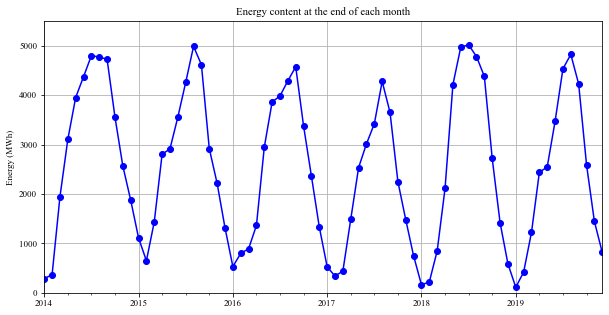

In [9]:
ax = Q_storage.resample('1M').last().iloc[:12*6].plot(figsize=(10,5), ylim=[0,5500], style='b-o', grid=True)
ax.set_title('Energy content at the end of each month')
ax.set_ylabel('Energy (MWh)')

Calculation for solar energy into and out of the storage. Note that ".pro" is the produced energy for the solar field, ".afbl" is the energy used for night cooling of the storage, and ".frost" is the energy used for defrosting the solar field in the winter.

In [10]:
# Q_solar_1 and 2 are the net solar energy entering the storage
df['Q_solar_1'] = df['so.f1.pro.energi.t'.upper()].diff() - df['so.f1.afbl.energi.t'.upper()].diff() - df['so.f1.frost.energi.t'.upper()].diff()
df['Q_solar_2'] = df['so.f2.pro.energi.t'.upper()].diff() - df['so.f2.afbl.energi.t'.upper()].diff() - df['so.f2.frost.energi.t'.upper()].diff()

# Q_transmission is the energy transfered out of the storgae
df['Q_transmission'] = (df['SO.LA.FT.469']/3600 * # Flow rate converted from m3/hr to m3/s
                        (df['SO.LA.TT.417']-df['SO.LA.TT.418']) * # Temperature difference
                        df['SO.LA.TT.418'].apply(density_water) * # Density at flow meter location
                        (0.5*df['SO.LA.TT.417'] + 0.5*df['SO.LA.TT.418']).apply(specific_heat_water) # Average temperature for finding the specific heat
                       )/6*10**-6 # Conversion to MWh

Calculation of the Charged and Discharged energy in the storage.

In [11]:
df['Q_storage'] = df['Q_solar_1'] + df['Q_solar_2'] - df['Q_transmission']

df['Q_discharge'] = -df['Q_storage'].clip(upper=0)
df['Q_charge'] = df['Q_storage'].clip(lower=0)

### Plots for water temperature and energy content of the storage.

In [12]:
# Create a new dataframe by taking the average temperature of 2 layers (end up with 16 water layers)
df_col = df[water_sensors]
df_col.columns = [int(float(c[2:])-0.5) for c in water_sensors]
df_col = df_col.groupby(df_col.columns, axis='columns').mean()
df_col = df_col.resample('1h').mean()

# Plot the first 5 lines of the dataset
df_col.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
2014-01-01 01:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 02:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 03:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 04:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 05:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


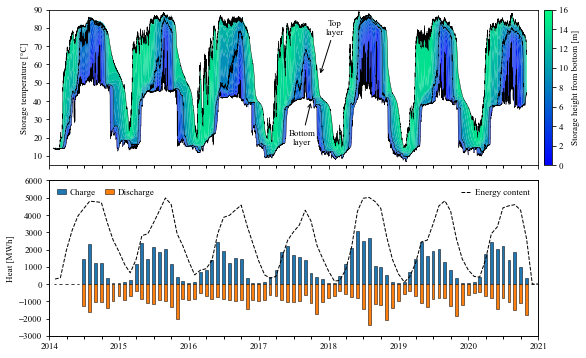

In [13]:
cmap = matplotlib.cm.get_cmap('winter') # Set the colormap for the different storage layers
bar_width = 15 # Set the bar width for the bar plot

# Create new dataframes for the plots in order not to change the original dataframe
dfw = df_col
dfr = df.resample('1M').sum()

# Make plot correlating the stratification number with charge and discharge periods
fig, axes = plt.subplots(nrows=2, figsize=(9,6), sharex=True)


# Temperature colors
for i in range(dfw.shape[1]-1):
    c1 = dfw.columns[i]
    c2 = dfw.columns[i+1]
    axes[0].fill_between(dfw.index, dfw[c2], dfw[c1],
                         where=dfw[c2] >= dfw[c1],
                         facecolor=cmap(i/len(dfw.columns)))

# Create temperature colorbar
divider = make_axes_locatable(axes[0])
cax_size, cax_pad = '1.5%', 0.08
cax = divider.append_axes("right", size=cax_size, pad=cax_pad)
cb = cbar.ColorbarBase(ax=cax, cmap=cmap, norm=plt.Normalize(0,16),
                       label='Storage height from bottom [m]')

# Plot 3 thin, black lines for indicating the top, middle, and bottom layer of the storage
axes[0].plot(dfw[dfw.columns[0]], c='k', lw=0.4)
axes[0].plot(dfw[dfw.columns[int(dfw.shape[1]/2)]], c='k', lw=0.4)
axes[0].plot(dfw[dfw.columns[-1]], c='k', lw=0.4)


# Bar plot for charged-discharged energy
axes[1].bar(dfr.index, dfr['Q_charge'], width=bar_width, label='Charge', edgecolor='k', linewidth=0.5)
axes[1].bar(dfr.index, -dfr['Q_discharge'], width=bar_width, label='Discharge', edgecolor='k', linewidth=0.5)
axes[1].legend(loc=2, ncol=2, frameon=False, handlelength=1, handleheight=0.5, columnspacing=1, handletextpad=0.4)

# Make twin y-axis for plotting the energy content of the storage
ax2 = axes[1].twinx()
ax2.plot(Q_storage.resample('1M').last(), c='k', linestyle='--', label='Energy content', lw=1)
ax2.legend(loc=1, frameon=False, handlelength=1, handletextpad=0.6)

# Set the y-limits for the axes
axes[0].set_ylim(5,90)
axes[1].set_ylim(-3000,6000)
ax2.set_ylim(-3000,6000)

# Set the ticks for the axes
axes[0].set_yticks(np.arange(10,90+10,10))
axes[1].set_yticks(np.arange(-3000,7000,1000))
ax2.set_yticks([])

# Set the format of the x-axis for showing the years as major ticks and minor ticks every 3 months
date_form = DateFormatter('%Y')
axes[1].xaxis.set_major_formatter(date_form)
xticks = pd.date_range('2014-1-1', freq='YS', periods=8)
axes[1].set_xticks(xticks)
minor_xticks = pd.date_range('2014-1-1', freq='3MS', periods=28)
axes[1].set_xticks(minor_xticks, minor=True)

# Set the dimensions of the minor x-ticks
for ax in axes:
    ax.tick_params('x', length=3, width=1, which='minor')

# Set the y-labels for the axes
axes[0].set_ylabel('Storage temperature [°C]')
axes[1].set_ylabel('Heat [MWh]')

# Create arrows for indicating the top and bottom storage layer
axes[0].annotate('Top\nlayer',
                 (pd.Timestamp(2017,11,15),54),
                 (pd.Timestamp(2018,2,1),80),
                 va='center', ha='center',
                arrowprops=dict(arrowstyle= '->', color='k'))

axes[0].annotate('Bottom\nlayer',
                 (pd.Timestamp(2017,10,1),40),
                 (pd.Timestamp(2017,8,15),20),
                 va='center', ha='center',
                arrowprops=dict(arrowstyle= '->', color='k'))

# Adjust all subplots to not use the right 2 %
for ax in [axes[1], ax2]:
    divider2 = make_axes_locatable(ax)
    cax2 = divider2.append_axes("right", size=cax_size, pad=cax_pad)
    cax2.remove()

# Set the x-limit for the plot
axes[-1].set_xlim(dt.datetime(2014,1,1),dt.datetime(2021,1,1))

# Adjust the white space between the plots
plt.subplots_adjust(hspace=0.1)

### Observation of temperature profile inside storage

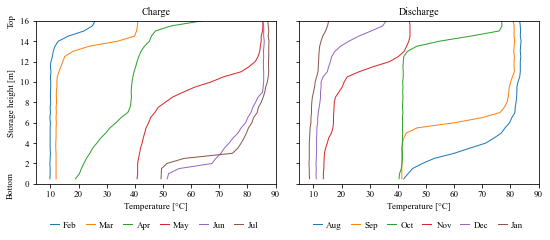

In [14]:
# Get the height of the sensors for plotting
water_sensors_heights = [float(c.split('_')[-1]) for c in water_sensors]

# Charge period from February to July
date_range_charge = pd.date_range(start='2018-02-01 00:00', periods=6, freq='1M').tz_localize('Etc/GMT-1')

# Discharge period August to January
date_range_discharge = pd.date_range(start='2018-08-01 00:00', periods=6, freq='1M').tz_localize('Etc/GMT-1')


fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(9,3))
# Create a dataframe for the plot with the water sensors for the charge period
df_vertical_ch = df.loc[date_range_charge, water_sensors].T
# Get the month name
df_vertical_ch.columns = [c.strftime('%b') for c in df_vertical_ch.columns]
# Get the sensor height
df_vertical_ch['height'] = water_sensors_heights
# Plot the two variables
for month in df_vertical_ch.columns[:-1]:
    df_vertical_ch.plot(x=month, y='height', ax=axes[0], label=month, lw=1)

# Create a dataframe for the plot with the water sensors for the discharge period
df_vertical_dis = df.loc[date_range_discharge, water_sensors].T
# Get the month name
df_vertical_dis.columns = [c.strftime('%b') for c in df_vertical_dis.columns]
# Get the sensor height
df_vertical_dis['height'] = water_sensors_heights
# Plot the two variables
for month in df_vertical_dis.columns[:-1]:
    df_vertical_dis.plot(x=month, y='height', ax=axes[1], label=month, lw=1)

# Set the titles of the plots and the labels of the x and y axes
axes[0].set_title('Charge', fontsize=10), axes[1].set_title('Discharge', fontsize=10)
axes[0].set_xlabel('Temperature [°C]'), axes[1].set_xlabel('Temperature [°C]')
axes[0].set_ylabel('Storage height [m]')

# Set the y limit of the graph
axes[0].set_ylim(0,16)

# Set the legend, ticks, and x-limit for the two subplots
for ax in axes:
    ax.legend(ncol= 6, loc=(0.04, -0.3), frameon=False, handlelength=1, columnspacing=1, handletextpad=0.5)
    xticks = np.arange(0,100,10)
    ax.set_xticks(xticks)
    ax.set_xlim(5,90)

# Text for explaining the y limits
plt.gcf().text(0.08, 0.065, 'Bottom', rotation=90)
plt.gcf().text(0.08, 0.86, 'Top', rotation=90)

# Adjust the white space between the two plots
fig.subplots_adjust(wspace=0.1, hspace=0)